# Introduction

[This package](https://cma-es.github.io/moarchiving/moarchiving-apidocs/index.html) implements a multi-objective 
 non-dominated archive for 2, 3 or 4 objectives, providing easy and fast access to multiple hypervolume indicators:

- the hypervolume of the entire archive,
- the contributing hypervolume of each element,
- the [uncrowded hypervolume improvement](https://doi.org/10.1145/3321707.3321852) (see also [here](https://arxiv.org/abs/1904.08823)) of any given point in the objective space, and
- the uncrowded hypervolume of the (unpruned) archive, here called [hypervolume plus](https://cma-es.github.io/moarchiving/moarchiving-apidocs/moarchiving.moarchiving.BiobjectiveNondominatedSortedList.html#hypervolume_plus).

Additionally, the package provides a constrained version of the archive,
which allows to store points with constraints.

The source code is available [on GitHub](https://github.com/CMA-ES/moarchiving).

## Installation

On a system shell, either like
```
pip install moarchiving
```

or from GitHub, for example
```
pip install git+https://github.com/CMA-ES/moarchiving.git@development
```
installing from the `development` branch.

## Testing

```
python -m moarchiving.test
```

on a system shell should output something like

```
doctest.testmod(<module 'moarchiving.moarchiving2obj' from '...\\moarchiving\\moarchiving2obj.py'>)
TestResults(failed=0, attempted=90)

...

OK
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromModule(<module 'moarchiving.tests.test_sorted_list' from '...\\moarchiving\\tests\\test_sorted_list.py'>))
.......
----------------------------------------------------------------------
Ran 7 tests in 0.001s
```


## Links

- [API documentation](https://cma-es.github.io/moarchiving/moarchiving-apidocs/index.html)
- [This page including performance test examples](https://cma-es.github.io/moarchiving/)
- [Code on Github](https://github.com/CMA-ES/moarchiving)


## Details

`moarchiving` with 2 objectives uses the [`fractions.Fraction`](https://docs.python.org/3/library/fractions.html) type to avoid rounding errors when computing hypervolume differences, but its usage can also be easily switched off by assigning the respective class attributes `hypervolume_computation_float_type` and `hypervolume_final_float_type`. The Fraction type can become prohibitively computationally expensive with increasing precision.

The implementation of the two-objective archive is heavily based on the [`bisect`](https://docs.python.org/3/library/bisect.html) module, while in three and four objectives it is based on the [`sortedcontainers`](https://pypi.org/project/sortedcontainers/) module.


## Releases
- 1.1.0 added possibility of normalization of the indicators by adding `ideal_point` and `weights` methods to the archive
- [1.0.0](https://github.com/CMA-ES/moarchiving/releases/tag/r1.0.0) addition of MOArchive classes for 3 and 4 objectives, as well as a class for handling solutions to constrained problems
- 0.7.0 reimplementation of `BiobjectiveNondominatedSortedList.hypervolume_improvement` by extracting a sublist first.
- 0.6.0 the `infos` attribute is a `list` with corresponding (arbitrary) information, e.g. for keeping the respective solutions.
- 0.5.3 fixed assertion error when not using `fractions.Fraction`
- 0.5.2 first published version

# Usage examples
1. [Initialization](#1-initialization)
2. [Constrained MOArchive](#2-constrained-moarchive)
3. [Accessing solution information](#3-accessing-solution-information)
4. [Adding solutions](#4-adding-solutions)
5. [Archive size](#5-archive-size)
6. [Performance indicators and normalization](#6-performance-indicators-and-normalization)
7. [Contributing hypervolumes](#7-contributing-hypervolumes)
8. [Hypervolume improvement](#8-hypervolume-improvement)
9. [Distance to the Pareto front](#9-distance-to-the-pareto-front)
10. [Enabling or disabling fractions](#10-enabling-or-disabling-fractions)
11. [Additional functions](#11-additional-functions)
12. [Visualization of indicator values](#12-visualization-of-indicator-values)
13. [Performance tests](#13-performance-tests)

### 1. Initialization
The MOArchive object can be created using the `get_mo_archive` function by providing a list of objective values, a reference point, or at least the number of objectives. 
Further solutions can be added using `add` or `add_list` methods, but the reference point cannot be changed once the instance is created. A list of information strings can be provided for each element, which will be stored as long as the corresponding element remains in the archive (e.g., the x values of the element). At any time, the list of non-dominated elements and their corresponding information can be accessed.

In [23]:
from moarchiving import get_mo_archive

moa2obj = get_mo_archive([[1, 5], [2, 3], [4, 5], [5, 0]], reference_point=[10, 10], infos=["a", "b", "c", "d"])
moa3obj = get_mo_archive([[1, 2, 3], [3, 2, 1], [3, 3, 0], [2, 2, 1]], [10, 10, 10], ["a", "b", "c", "d"])
moa4obj = get_mo_archive([[1, 2, 3, 4], [1, 3, 4, 5], [4, 3, 2, 1], [1, 3, 0, 1]], reference_point=[10, 10, 10, 10], infos=["a", "b", "c", "d"])

print("points in the 2 objective archive:", list(moa2obj))
print("points in the 3 objective archive:", list(moa3obj))
print("points in the 4 objective archive:", list(moa4obj))

points in the 2 objective archive: [[1, 5], [2, 3], [5, 0]]
points in the 3 objective archive: [[3, 3, 0], [2, 2, 1], [1, 2, 3]]
points in the 4 objective archive: [[1, 3, 0, 1], [1, 2, 3, 4]]


MOArchive objects can also be initialized empty.

In [24]:
moa = get_mo_archive(reference_point=[4, 4, 4])
print("points in the empty archive:", list(moa))

points in the empty archive: []


### 2. Constrained MOArchive
Constrained MOArchive supports all the functionalities of a non-constrained MOArchive, with the added capability of handling constraints when adding or initializing the archive. In addition to the objective values of a solution, constraint values must be provided in the form of a list or a number. A solution is deemed feasible and added to the archive when all its constraint values are less than or equal to zero. 

In [25]:
from moarchiving import get_cmo_archive

cmoa = get_cmo_archive([[1, 2, 3], [1, 3, 4], [4, 3, 2], [1, 3, 0]], [[3, 0], [0, 0], [0, 0], [0, 1]], 
                       reference_point=[5, 5, 5], infos=["a", "b", "c", "d"])
print("points in the archive:", list(cmoa))

points in the archive: [[4, 3, 2], [1, 3, 4]]


### 3. Accessing solution information
`archive.infos` is used to get the information on solutions in the archive.

In [26]:
# infos of the previously defined empty archive
print("infos of the empty archive", moa.infos)
print("infos of the constrained archive", cmoa.infos)

infos of the empty archive []
infos of the constrained archive ['c', 'b']


### 4. Adding solutions
Solutions can be added to the MOArchive at any time using the `add` function (for a single solution) or the `add_list` function (for multiple solutions).

In [27]:
moa.add([1, 2, 3], "a")
print("points:", list(moa))
print("infos:", moa.infos)

moa.add_list([[3, 2, 1], [2, 3, 2], [2, 2, 2]], ["b", "c", "d"])
print("points:", list(moa))
print("infos:", moa.infos)

points: [[1, 2, 3]]
infos: ['a']
points: [[3, 2, 1], [2, 2, 2], [1, 2, 3]]
infos: ['b', 'd', 'a']


When adding to the constrained archive, constraint values must be added as well.

In [28]:
cmoa.add_list([[3, 3, 3], [1, 1, 1]], [[0, 0], [42, 0]], ["e", "f"])
print("points:", list(cmoa))
print("infos:", cmoa.infos)

points: [[4, 3, 2], [3, 3, 3], [1, 3, 4]]
infos: ['c', 'e', 'b']


### 5. Archive size
The MOArchive implements some functionality of a list (in the 2 objective case, it actually extends the `list` class, though this is not the case in 3 and 4 objectives).  In particular, it includes the `len` method to get the number of solutions in the archive as well as the `in` keyword to check if a point is in the archive.

In [29]:
print("Points in the archive:", list(moa))
print("Length of the archive:", len(moa))
print("[2, 2, 2] in moa:", [2, 2, 2] in moa)
print("[3, 2, 0] in moa:", [3, 2, 0] in moa)

Points in the archive: [[3, 2, 1], [2, 2, 2], [1, 2, 3]]
Length of the archive: 3
[2, 2, 2] in moa: True
[3, 2, 0] in moa: False


### 6. Performance indicators and normalization
An archive provides the following performance indicators:
- `hypervolume`
- `hypervolume_plus`, providing additionally the closest distance to the reference area for an empty archive, see [here](https://doi.org/10.1145/3321707.3321852) and [here](https://doi.org/10.1109/TEVC.2022.3210897)
- `hypervolume_plus_constr` (for CMOArchive), based on, but not completely equal to the one defined [here](https://doi.org/10.1016/j.ins.2022.05.106)

Indicators are defined for maximization (the original `hypervolume_plus_constr` indicator is multiplied by -1). When the archive is not empty, all the indicators are positive and have the same value. The values of indicators are normalized, if the user specifies the ideal point, which can be done at the initialization using `ideal_point` keyword or later using `ideal_point` method. Custom weights for each dimension can be set in the same way using `weights` keyword or method. The default weights are equal to 1 for all objectives.


In [30]:
# not normalized values
print("Hypervolume of the archive:", moa.hypervolume)
print("Hypervolume plus of the archive:", moa.hypervolume_plus)

# add ideal point
moa.ideal_point([0, 0, 0])
print("Hypervolume of the normalized archive:", moa.hypervolume)

# add also weights
moa.weights([2, 3, 5])
print("Hypervolume of the normalized archive with weights:", moa.hypervolume)

Hypervolume of the archive: 12
Hypervolume plus of the archive: 12
Hypervolume of the normalized archive: 0.1875
Hypervolume of the normalized archive with weights: 5.625


When using constrained moarchive, the constraint violations can be normalized as well, if the list of max violations is provided.

In [31]:
cmoa = get_cmo_archive([[1, 2, 3], [4, 4, 2], [3, 3, 3]], [[0, 10], [0.3, 4], [1, 0]], 
                       reference_point=[5, 5, 5], ideal_point=[0, 0, 0], max_g_vals=[1, 10], tau=1)

In case of a constrained MOArchive, the `hypervolume_plus_constr` attribute can be accessed as well. 

In [32]:
print("Hyperolume of the constrained archive:", cmoa.hypervolume)
print("Hypervolume plus of the constrained archive:", cmoa.hypervolume_plus)
print("Hypervolume plus constr of the constrained archive:", cmoa.hypervolume_plus_constr)

Hyperolume of the constrained archive: 0.0
Hypervolume plus of the constrained archive: -inf
Hypervolume plus constr of the constrained archive: -1.7


In [33]:
cmoa.add([6, 6, 6], [0, 0])
print("Hyperolume of the constrained archive:", cmoa.hypervolume)
print("Hypervolume plus of the constrained archive:", cmoa.hypervolume_plus)
print("Hypervolume plus constr of the constrained archive:", cmoa.hypervolume_plus_constr)

Hyperolume of the constrained archive: 0.0
Hypervolume plus of the constrained archive: -0.3464101615137755
Hypervolume plus constr of the constrained archive: -0.3464101615137755


### 7. Contributing hypervolumes
The `contributing_hypervolumes` attribute provides a list of hypervolume contributions for each point of the archive. Alternatively, the contribution for a single point can be computed using the `contributing_hypervolume(point)` method.

In [34]:
for i, objectives in enumerate(moa):
    assert moa.contributing_hypervolume(objectives) == moa.contributing_hypervolumes[i]
    print("contributing hv of point", objectives, "is", moa.contributing_hypervolume(objectives))

print("All contributing hypervolumes:", moa.contributing_hypervolumes)

contributing hv of point [3, 2, 1] is 0.9375
contributing hv of point [2, 2, 2] is 0.9375
contributing hv of point [1, 2, 3] is 0.9375
All contributing hypervolumes: [0.9375, 0.9375, 0.9375]


### 8. Hypervolume improvement
The `hypervolume_improvement(point)` method returns the improvement of the hypervolume if we would add the point to the archive.

In [35]:
point = [1, 3, 0]
print(f"hypervolume before adding {point}: {moa.hypervolume}")
print(f"hypervolume improvement of point {point}: {moa.hypervolume_improvement(point)}")
moa.add(point)
print(f"hypervolume after adding {point}: {moa.hypervolume}")

hypervolume before adding [1, 3, 0]: 5.625
hypervolume improvement of point [1, 3, 0]: 2.8125
hypervolume after adding [1, 3, 0]: 8.4375


### 9. Distance to the empirical Pareto front
The `distance_to_pareto_front(point)` method returns the distance between the given point and the Pareto front.

In [36]:
print(f"Current archive: {list(moa)}")
print("Distance of [3, 2, 1] to pareto front:", moa.distance_to_pareto_front([3, 2, 1]))
print("Distance of [3, 2, 2] to pareto front:", moa.distance_to_pareto_front([3, 3, 3]))

Current archive: [[1, 3, 0], [3, 2, 1], [2, 2, 2], [1, 2, 3]]
Distance of [3, 2, 1] to pareto front: 0.0
Distance of [3, 2, 2] to pareto front: 0.5


### 10. Enabling or disabling fractions 
To avoid loss of precision, fractions are used by default. This can be changed to floats by setting the `hypervolume_final_float_type` and `hypervolume_computation_float_type` function attributes.

In [37]:
import fractions
get_mo_archive.hypervolume_computation_float_type = fractions.Fraction
get_mo_archive.hypervolume_final_float_type = fractions.Fraction

moa3_fr = get_mo_archive([[1, 2, 3], [2, 1, 3], [3, 3, 1.32], [1.3, 1.3, 3], [1.7, 1.1, 2]], reference_point=[4, 4, 4])
print(moa3_fr.hypervolume)

get_mo_archive.hypervolume_computation_float_type = float
get_mo_archive.hypervolume_final_float_type = float

moa3_nofr = get_mo_archive([[1, 2, 3], [2, 1, 3], [3, 3, 1.32], [1.3, 1.3, 3], [1.7, 1.1, 2]], reference_point=[4, 4, 4])
print(moa3_nofr.hypervolume)

161245156349030777798724819133399/10141204801825835211973625643008
15.899999999999999


### 11. Additional functions
MOArchive also implements additional functions to check whether a given point is in the archive:
- `in_domain`: Is the point in the domain?
- `dominates`: Is the point dominated by the archive?
- `dominators`: Which points (and how many) dominate the given point?

In [38]:
points_list = [[5, 5, 0], [2, 2, 3], [0, 2, 3]]
print("archive:", list(moa), "\n")
print("point     | in domain | dominates | num of dominators | dominators")
print("----------|-----------|-----------|-------------------|-----------")
for point in points_list:
    print(f"{point} | {moa.in_domain(point):9} | {moa.dominates(point):9} | "
          f"{moa.dominators(point, number_only=True):17} | {moa.dominators(point)}")

archive: [[1, 3, 0], [3, 2, 1], [2, 2, 2], [1, 2, 3]] 

point     | in domain | dominates | num of dominators | dominators
----------|-----------|-----------|-------------------|-----------
[5, 5, 0] |         0 |         1 |                 1 | [[1, 3, 0]]
[2, 2, 3] |         1 |         1 |                 2 | [[2, 2, 2], [1, 2, 3]]
[0, 2, 3] |         1 |         0 |                 0 | []


### 12. Visualization of indicator values
By saving the values of indicators for each solution added to the archive, we can visualize their change over time.

In [48]:
import matplotlib.pyplot as plt
import random

n_obj = 3

indicators_cmoa = []
indicators_moa = []
cmoa = get_cmo_archive(reference_point=[0.5] * n_obj, n_obj=n_obj, tau=0.2)
moa = get_mo_archive(reference_point=[0.1] * n_obj, n_obj=n_obj)

for i in range(2000):
    objectives = [random.random() for _ in range(n_obj)]
    constraints = [max(random.random() - 0.1, 0), max(random.random() - 0.1, 0)]
    
    cmoa.add(objectives, constraints, info=f"point_{i}")
    moa.add(objectives, info=f"point_{i}")
    
    indicators_cmoa.append((cmoa.hypervolume_plus_constr, cmoa.hypervolume_plus, cmoa.hypervolume))
    indicators_moa.append((moa.hypervolume_plus, moa.hypervolume))
    

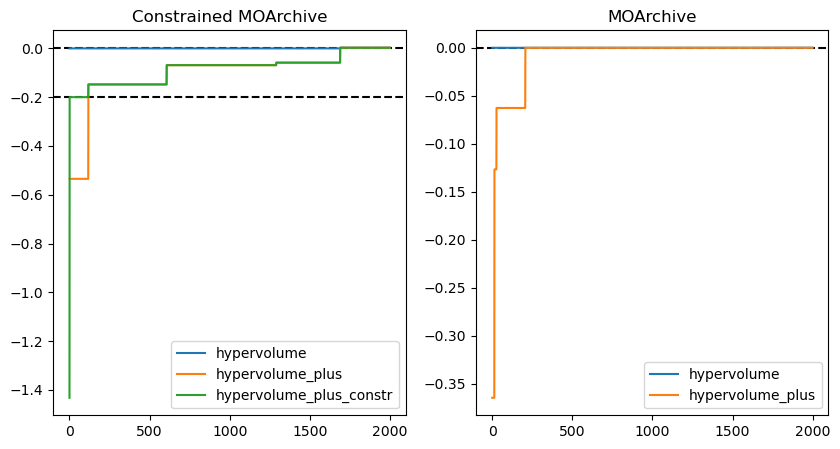

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot([x[2] for x in indicators_cmoa], label="hypervolume")
axs[0].plot([x[1] for x in indicators_cmoa], label="hypervolume_plus")
axs[0].plot([x[0] for x in indicators_cmoa], label="hypervolume_plus_constr")
axs[0].axhline(0, color="black", linestyle="--", zorder=0)
axs[0].axhline(-cmoa.tau, color="black", linestyle="--", zorder=0)
axs[0].set_title("Constrained MOArchive")
axs[0].legend()

axs[1].plot([x[1] for x in indicators_moa], label="hypervolume")
axs[1].plot([x[0] for x in indicators_moa], label="hypervolume_plus")
axs[1].set_title("MOArchive")
axs[1].axhline(0, color="black", linestyle="--", zorder=0)
axs[1].legend()
plt.show()

### 13. Performance tests

In [41]:
import time
from moarchiving.tests.point_sampling import get_non_dominated_points
test_archive_sizes = [0] + [2 ** i for i in range(21)]

get_mo_archive.hypervolume_computation_float_type = fractions.Fraction
get_mo_archive.hypervolume_final_float_type = fractions.Fraction

#### 13.1. Initializing the archive

Testing 2 objectives
..............
Testing 3 objectives
.............
Testing 4 objectives
.........


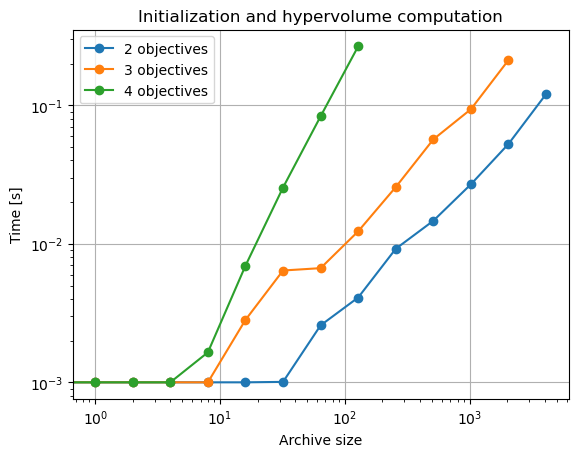

In [42]:
n_repeats = 100
time_limit = 10

for n_obj in [2, 3, 4]:
    print(f"Testing {n_obj} objectives")
    times = []
    archive_sizes = []
    
    for archive_size in test_archive_sizes:
        points = get_non_dominated_points(archive_size, n_dim=n_obj)
        t0 = time.time()
        moa = [get_mo_archive(points, [1] * n_obj, n_obj=n_obj)
               for _ in range(n_repeats)]
        hv = [m.hypervolume for m in moa]
        t1 = time.time()
        
        times.append(max((t1 - t0) / n_repeats, 10e-4))
        print(".", end="")
        archive_sizes.append(archive_size)
        
        if t1 - t0 > time_limit:
            break
    print()
    
    plt.plot(archive_sizes, times, '-o', label=f"{n_obj} objectives")

plt.title("Initialization and hypervolume computation")
plt.xlabel("Archive size")
plt.ylabel("Time [s]")
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.legend()
plt.show()

#### 13.2. Adding a solution to an existing archive

Testing 2 objectives
......................
Testing 3 objectives
................
Testing 4 objectives
...........


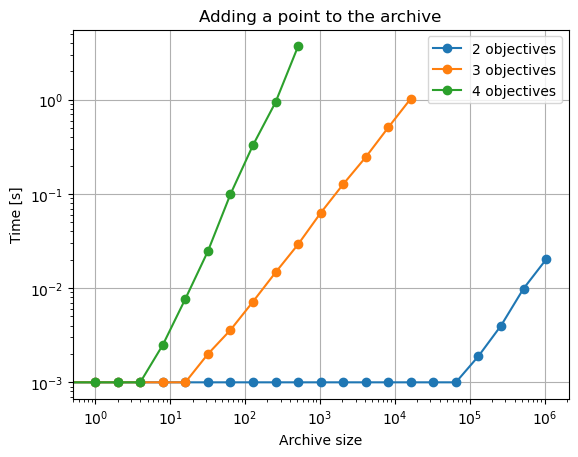

In [43]:
n_repeats = 10
time_limit = 10

for n_obj in [2, 3, 4]:
    print(f"Testing {n_obj} objectives")
    times = []
    archive_sizes = []

    for archive_size in test_archive_sizes:
        
        points = get_non_dominated_points(archive_size, n_dim=n_obj)
        add_points = get_non_dominated_points(n_repeats, n_dim=n_obj)
        moa = [get_mo_archive(points, [1] * n_obj, n_obj=n_obj) for _ in range(n_repeats)]
        
        t0 = time.time()
        for i, m in enumerate(moa):
            m.add(add_points[i])
        t1 = time.time()

        times.append(max((t1 - t0) / n_repeats, 10e-4))
        print(".", end="")
        archive_sizes.append(archive_size)

        if t1 - t0 > time_limit:
            break
    print()
    time.sleep(1)

    plt.plot(archive_sizes, times, '-o', label=f"{n_obj} objectives")

plt.title("Adding a point to the archive")
plt.xlabel("Archive size")
plt.ylabel("Time [s]")
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.legend()
plt.show()